# Proyek Klasifikasi Gambar


*   Nama : Latifah Arum Sulistyaningsih
*   Id Dicoding: latifaharums  (latifaharums123@gmail.com)

Dataset diambil dari kaggle https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols/code



> Handwritten Math Symbol Dataset from MNIST



In [1]:
pip install python-mnist

## Library yang digunakan

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from mnist import MNIST
from mnist.loader import MNIST
import os
import zipfile
from sklearn.model_selection import train_test_split

## Load dataset

!pip install kagglehub --upgrade


In [3]:
from google.colab import files
files.upload()  # pilih kaggle.json


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifaharums","key":"59f9b763fed51c563795f5dce569363f"}'}

In [4]:
import os
import shutil

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move("kaggle (2).json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [5]:
!kaggle datasets download -d crawford/emnist

Dataset URL: https://www.kaggle.com/datasets/crawford/emnist
License(s): CC0-1.0
100% 1.24G/1.24G [00:05<00:00, 240MB/s]
100% 1.24G/1.24G [00:05<00:00, 225MB/s]


Dataset saya download langsung dari kaggle karena 1.24 GB jadi kalau di upload via drive atau run di laptop biar mudah dan tidak berat.

> Saya pakai GPU T4 agar proses klasifikasi gambar cepat di running.



In [6]:
#Extract file yang ada
import zipfile

with zipfile.ZipFile("emnist.zip", "r") as zip_ref:
    zip_ref.extractall("emnist_data")

In [7]:
#Cek direktori ada file nya tidak
import os
os.listdir("emnist_data")

['emnist-mnist-mapping.txt',
 'emnist-byclass-train.csv',
 'emnist-byclass-mapping.txt',
 'emnist-bymerge-train.csv',
 'emnist-letters-test.csv',
 'emnist-digits-train.csv',
 'emnist-bymerge-mapping.txt',
 'emnist-digits-test.csv',
 'emnist-mnist-train.csv',
 'emnist-bymerge-test.csv',
 'emnist-letters-mapping.txt',
 'emnist-balanced-mapping.txt',
 'emnist_source_files',
 'emnist-balanced-train.csv',
 'emnist-balanced-test.csv',
 'emnist-byclass-test.csv',
 'emnist-letters-train.csv',
 'emnist-digits-mapping.txt',
 'emnist-mnist-test.csv']

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data train dan test dari file CSV
train_df = pd.read_csv("emnist_data/emnist-balanced-train.csv", header=None)
test_df = pd.read_csv("emnist_data/emnist-balanced-test.csv", header=None)

# Gabungkan train dan test jadi satu dataset
full_df = pd.concat([train_df, test_df], axis=0)

# Split label dan fitur
y = full_df.iloc[:, 0].values
X = full_df.iloc[:, 1:].values / 255.0  # Normalisasi

In [9]:
# Bagi menjadi train (70%) dan sisa (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Bagi sisa menjadi validation (15%) dan test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [10]:
# Cetak ukuran masing-masing set

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (92120, 784)
Validation shape: (19740, 784)
Test shape: (19740, 784)


Total gambar lebih dari 100k images

In [11]:
# Reshape ke (28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

## One hot encoding label untuk model CNN

In [12]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# One-hot encoding
num_classes = len(np.unique(y))

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [13]:
# Cek hasil
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_val shape:", X_val.shape)
print("y_val_cat shape:", y_val_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

X_train shape: (92120, 28, 28, 1)
y_train_cat shape: (92120, 47)
X_val shape: (19740, 28, 28, 1)
y_val_cat shape: (19740, 47)
X_test shape: (19740, 28, 28, 1)
y_test_cat shape: (19740, 47)


## Modelling CNN

In [14]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape
from keras.constraints import max_norm
from keras import optimizers

model = Sequential()

# Conv layers
model.add(Convolution2D(32, (5, 5), activation='relu', padding='same', kernel_constraint=max_norm(3)))
model.add(Convolution2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten dan Dense
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_constraint=max_norm(3)))
model.add(Dense(512, activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Menerapkan Callbacks sesuai akurasi yang terbaik

In [16]:
# Buat callback pake earlystopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32)
validation_generator = validation_datagen.flow(X_test, y_test_cat, batch_size=32)


history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2872/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6863 - loss: 1.0585

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.6865 - loss: 1.0574 - val_accuracy: 0.8561 - val_loss: 0.4028
Epoch 2/50
2869/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8627 - loss: 0.3863

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8627 - loss: 0.3864 - val_accuracy: 0.8629 - val_loss: 0.3854
Epoch 3/50
2874/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8754 - loss: 0.3416

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8754 - loss: 0.3416 - val_accuracy: 0.8675 - val_loss: 0.3753
Epoch 4/50
2875/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8870 - loss: 0.3050

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8870 - loss: 0.3050 - val_accuracy: 0.8677 - val_loss: 0.3802
Epoch 5/50
2878/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8939 - loss: 0.2804

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8939 - loss: 0.2804 - val_accuracy: 0.8705 - val_loss: 0.3770
Epoch 6/50
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9009 - loss: 0.2643 - val_accuracy: 0.8673 - val_loss: 0.4037
Epoch 7/50
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9015 - loss: 0.2583 - val_accuracy: 0.8661 - val_loss: 0.3936


## Evaluasi

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    X_test,
    y_test_cat,
    batch_size=32
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi pada test set: {test_accuracy * 100:.2f}%")


617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8692 - loss: 0.3876
Akurasi pada test set: 87.05%


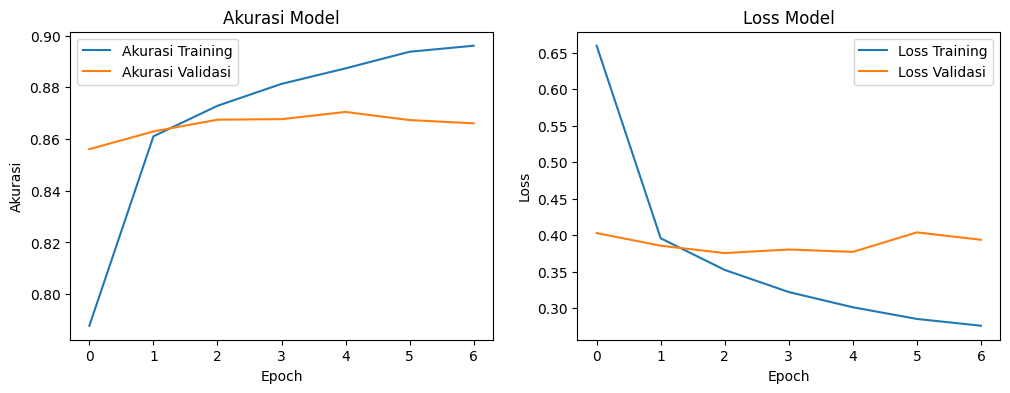

In [19]:
# Plot Akurasi dan Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [20]:
from google.colab import files

os.makedirs('/content/saved_model', exist_ok=True)
os.makedirs('/content/tflite', exist_ok=True)
os.makedirs('/content/tfjs_model', exist_ok=True)

In [21]:
# SAVEDMODEL
saved_model_path = '/content/saved_model'
model.export(saved_model_path)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_path}")

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 47), dtype=tf.float32, name=None)
Captures:
  136833255595792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255599632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255595408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255600784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255600016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255601744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255601552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255602512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255602320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255603280: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasi

In [22]:
# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = '/content/tflite/model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Buat file label.txt untuk TF-Lite
unique_labels = np.unique(y_train)
class_names = [str(label) for label in sorted(unique_labels)]

label_path = '/content/tflite/label.txt'
with open(label_path, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")
print(f"Model dan label berhasil disimpan dalam format TF-Lite di: /content/tflite")

Saved artifact at '/tmp/tmpgbs_1h77'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 47), dtype=tf.float32, name=None)
Captures:
  136833255595792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255599632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255595408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255600784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255600016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255601744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255601552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255602512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255602320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136833255603280: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model dan label b

In [23]:
# TFJS
!pip install tensorflowjs -q
import tensorflowjs as tfjs

tfjs_model_path = '/content/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_model_path)
print(f"Model berhasil disimpan dalam format TFJS di: {tfjs_model_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TFJS di: /content/tfjs_model


In [24]:
# Unduh model
zip_path = '/content/models.zip'
!zip -r {zip_path} /content/saved_model /content/tflite /content/tfjs_model
print(f"Semua model dikompresi ke: {zip_path}")

# Unduh file zip otomatis
files.download(zip_path)

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 62%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/saved_model.pb (deflated 84%)
  adding: content/tflite/ (stored 0%)
  adding: content/tflite/model.tflite (deflated 7%)
  adding: content/tflite/label.txt (deflated 45%)
  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard2of6.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard1of6.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 83%)
  adding: content/tfjs_model/group1-shard5of6.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard3of6.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard6of6.bin (deflated 7%)
  adding: content/tfjs_mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Inference

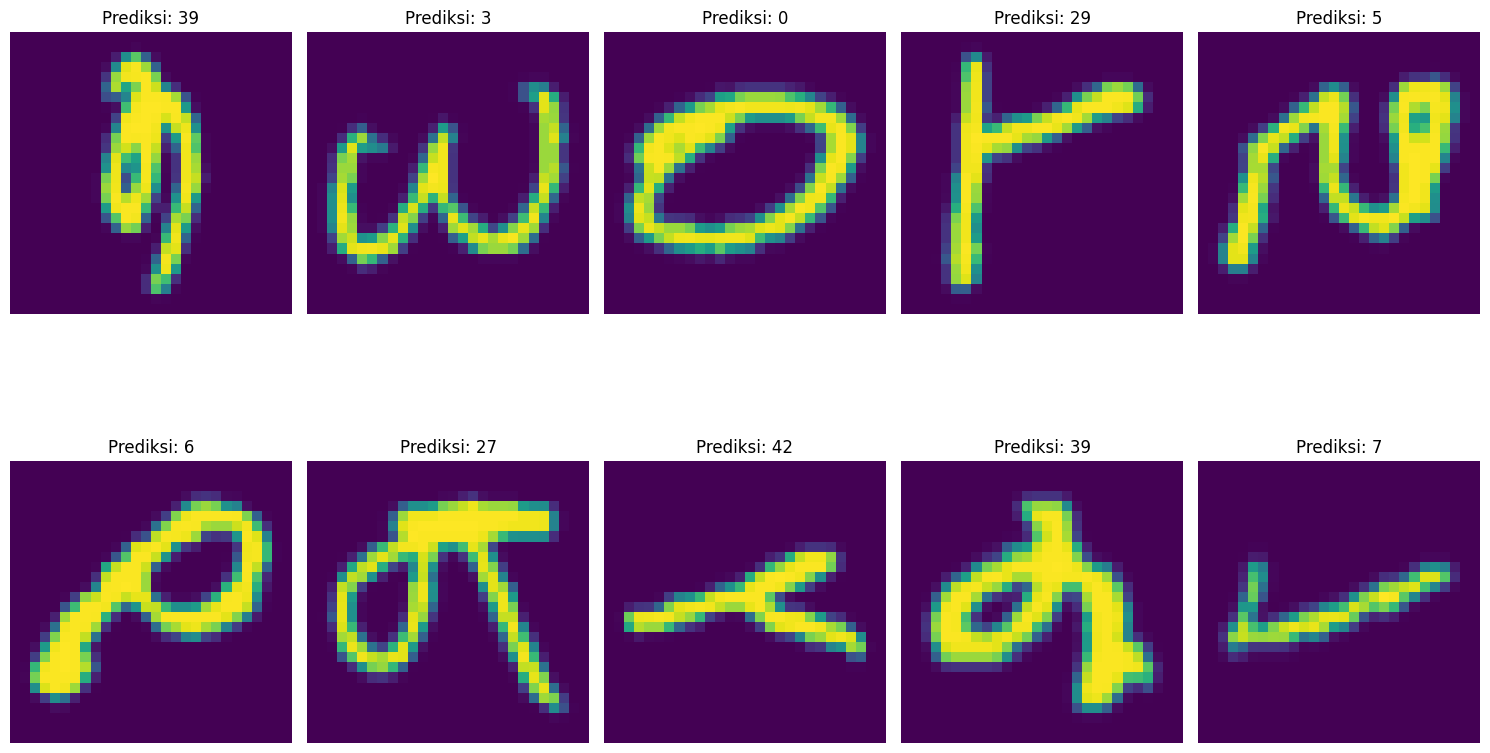

In [26]:
# Inference

interpreter = tf.lite.Interpreter(model_path='/content/tflite/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

jml_gambar = 10
sample_images, sample_labels = next(test_generator)
sample_images = sample_images[:jml_gambar]

predictions = []

for i in range(jml_gambar):
    input_image = np.expand_dims(sample_images[i], axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data[0])
    predictions.append(class_names[predicted_class])

plt.figure(figsize=(15, 10))
for i in range(jml_gambar):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Prediksi: {predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
!pip freeze > /content/requirements.txt